### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from os.path import join
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

### File paths and columns

In [5]:
RECORDING_DIR = "recordings"
OUTPUT_DIR = "output_wav"
MECH_READINGS_FILE = "mechanical_sensor.csv"
SOUND_READINGS_FILE = "sound_sensor.csv"

In [6]:
mech_cols = ["date", "time", "ntipps", "rainfall (mm)"]
mech_cols_desired = ["datetime", "ntipps", "rainfall (mm)"]
sound_cols = ["date", "time", "sound", "loudness"]
sound_cols_desired = ["datetime", "sound", "loudness"]
col_names = ["raw_audio", "filtered_audio"]

### Read files

In [7]:
mech_file_path = join(RECORDING_DIR, MECH_READINGS_FILE)
mech_data = pd.read_csv(mech_file_path, names=mech_cols)

sound_file_path = join(RECORDING_DIR, SOUND_READINGS_FILE)
sound_data = pd.read_csv(sound_file_path, names=sound_cols)

In [8]:
mech_data

,date,time,ntipps,rainfall (mm)
0,2023-10-3,22:37,0,0.00 mm
1,2023-10-3,22:38,0,0.00 mm
2,2023-10-3,22:39,0,0.00 mm
3,2023-10-3,22:40,0,0.00 mm
4,2023-10-3,22:43,0,0.00 mm
...,...,...,...,...
591,2023-10-4,8:30,0,0.00 mm
592,2023-10-4,8:31,0,0.00 mm
593,2023-10-4,8:32,0,0.00 mm
594,2023-10-4,8:33,0,0.00 mm


In [9]:
cutoff_value = 0.0

### Clean data

In [10]:
def process_mech_data(df):
    df["datetime"] = df["date"]+" "+df["time"]
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.drop(["date", "time"], axis=1)
    df = df[mech_cols_desired]
    df["rainfall (mm)"] = df["rainfall (mm)"].str.split(" ").str[1]
    df["rainfall (mm)"] = df["rainfall (mm)"].astype(float)
    df = df[df["rainfall (mm)"]>cutoff_value]
    return df

In [11]:
def process_sound_data(df):
    df["time"] = df["time"].str.split(":").str[:-1].str.join(":")
    df["date"] = df["date"].str.split("/").str[::-1].str.join("-")
    df["datetime"] = df["date"]+" "+df["time"]
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.drop(["date", "time"], axis=1)
    df = df[sound_cols_desired]
    df["sound"] = df["sound"].astype(float)
    df["loudness"] = df["loudness"].astype(float)
    return df

In [12]:
mech_data = process_mech_data(mech_data)
sound_data = process_sound_data(sound_data)

### Filter matching points

In [13]:
timepoints = list(set(sound_data["datetime"]).intersection(mech_data["datetime"]))
sound_data = sound_data.loc[sound_data["datetime"].isin(timepoints)]
mech_data = mech_data.loc[mech_data["datetime"].isin(timepoints)]

### Merge data and compute time difference to last reading

In [14]:
data_merged = pd.merge(mech_data, sound_data, on="datetime", how="inner")

In [15]:
data_merged['timedelta'] = (data_merged["datetime"]-data_merged["datetime"].shift()).fillna(pd.Timedelta(0))

In [16]:
data_merged["timedelta_min"] = data_merged["timedelta"].dt.total_seconds().div(60).astype(int)

In [17]:
data_merged

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
0,2023-10-03 22:52:00,2,0.56,378.0,137.0,0 days 00:00:00,0
1,2023-10-03 22:53:00,2,0.56,360.0,128.0,0 days 00:01:00,1
2,2023-10-03 23:29:00,4,1.12,380.0,141.0,0 days 00:36:00,36
3,2023-10-04 01:44:00,1,0.28,384.0,137.0,0 days 02:15:00,135
4,2023-10-04 01:52:00,1,0.28,396.0,146.0,0 days 00:08:00,8
5,2023-10-04 02:07:00,1,0.28,377.0,142.0,0 days 00:15:00,15
6,2023-10-04 02:25:00,1,0.28,388.0,137.0,0 days 00:18:00,18
7,2023-10-04 02:35:00,1,0.28,392.0,150.0,0 days 00:10:00,10
8,2023-10-04 02:37:00,1,0.28,395.0,148.0,0 days 00:02:00,2
9,2023-10-04 02:38:00,3,0.84,388.0,142.0,0 days 00:01:00,1


### Scatter plot

Text(0.5, 1.0, 'Rainfall vs. loudness scatter plot')

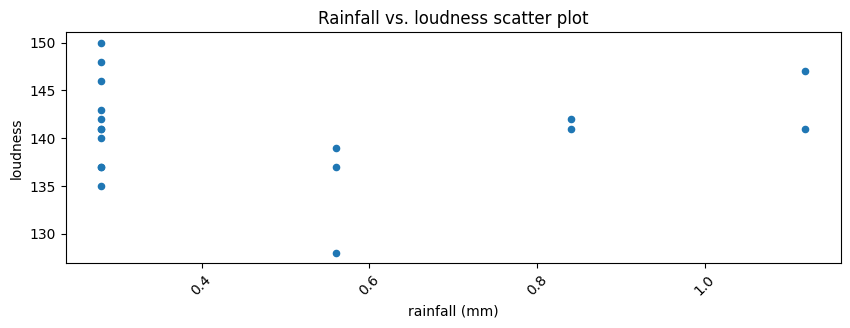

In [18]:
data_merged.plot(x="rainfall (mm)", y="loudness", kind='scatter', rot=45, figsize=(10,3))
plt.title("Rainfall vs. loudness scatter plot")

### Basic correlation analysis

#### Pearson Correlation

In [19]:
data_merged.corr(method='pearson')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,-0.337294,-0.337294,0.744423,0.477797,0.324207,0.324207
ntipps,-0.337294,1.000000,1.000000,-0.148040,0.033542,-0.200516,-0.200516
rainfall (mm),-0.337294,1.000000,1.000000,-0.148040,0.033542,-0.200516,-0.200516
sound,0.744423,-0.148040,-0.148040,1.000000,0.644813,0.448797,0.448797
loudness,0.477797,0.033542,0.033542,0.644813,1.000000,-0.024400,-0.024400
timedelta,0.324207,-0.200516,-0.200516,0.448797,-0.024400,1.000000,1.000000
timedelta_min,0.324207,-0.200516,-0.200516,0.448797,-0.024400,1.000000,1.000000


#### Spearman Rank Correlation

In [20]:
data_merged.corr(method='spearman')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,-0.269885,-0.269885,0.350751,0.164332,-0.044678,-0.044678
ntipps,-0.269885,1.000000,1.000000,-0.134701,-0.045729,-0.449480,-0.449480
rainfall (mm),-0.269885,1.000000,1.000000,-0.134701,-0.045729,-0.449480,-0.449480
sound,0.350751,-0.134701,-0.134701,1.000000,0.605848,0.141846,0.141846
loudness,0.164332,-0.045729,-0.045729,0.605848,1.000000,0.167245,0.167245
timedelta,-0.044678,-0.449480,-0.449480,0.141846,0.167245,1.000000,1.000000
timedelta_min,-0.044678,-0.449480,-0.449480,0.141846,0.167245,1.000000,1.000000


### Rainfall vs. Time to Previous Reading Plot

<Axes: xlabel='rainfall (mm)', ylabel='timedelta_min'>

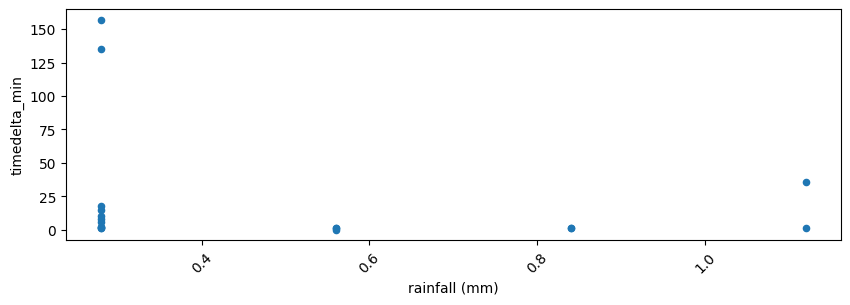

In [21]:
data_merged.plot(x="rainfall (mm)", y="timedelta_min", kind='scatter', rot=45, figsize=(10,3))

### Remove drizzling long rain

In [22]:
data_merged = data_merged[data_merged["rainfall (mm)"]>0.28]

In [23]:
data_merged.shape

(7, 7)

<Axes: xlabel='rainfall (mm)', ylabel='loudness'>

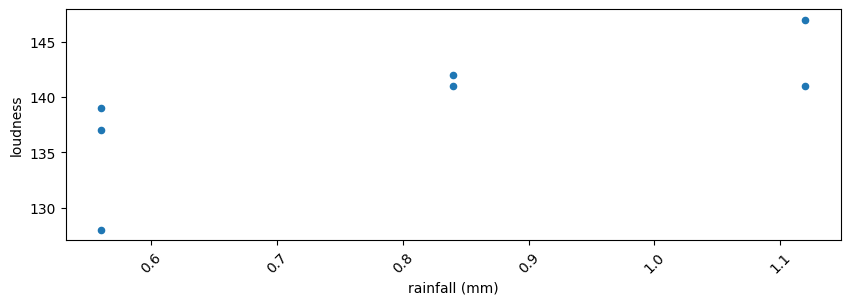

In [24]:
data_merged.plot(x="rainfall (mm)", y="loudness", kind='scatter', rot=45, figsize=(10,3))

<Axes: xlabel='rainfall (mm)', ylabel='sound'>

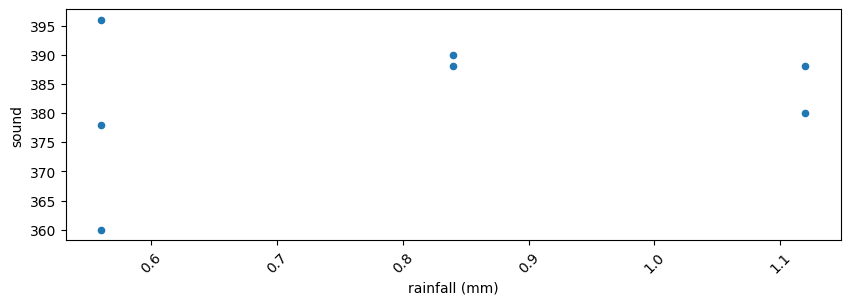

In [25]:
data_merged.plot(x="rainfall (mm)", y="sound", kind='scatter', rot=45, figsize=(10,3))

### Redo correlation analysis

In [26]:
data_merged.corr(method='pearson')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,0.273382,0.273382,0.838586,0.677839,-0.359220,-0.359220
ntipps,0.273382,1.000000,1.000000,0.265357,0.737172,0.569179,0.569179
rainfall (mm),0.273382,1.000000,1.000000,0.265357,0.737172,0.569179,0.569179
sound,0.838586,0.265357,0.265357,1.000000,0.789777,-0.101341,-0.101341
loudness,0.677839,0.737172,0.737172,0.789777,1.000000,0.133423,0.133423
timedelta,-0.359220,0.569179,0.569179,-0.101341,0.133423,1.000000,1.000000
timedelta_min,-0.359220,0.569179,0.569179,-0.101341,0.133423,1.000000,1.000000


In [27]:
data_merged.corr(method='spearman')

,datetime,ntipps,rainfall (mm),sound,loudness,timedelta,timedelta_min
datetime,1.000000,0.264575,0.264575,0.900937,0.540562,0.267261,0.267261
ntipps,0.264575,1.000000,1.000000,0.152554,0.839047,0.636396,0.636396
rainfall (mm),0.264575,1.000000,1.000000,0.152554,0.839047,0.636396,0.636396
sound,0.900937,0.152554,0.152554,1.000000,0.472727,0.134840,0.134840
loudness,0.540562,0.839047,0.839047,0.472727,1.000000,0.337100,0.337100
timedelta,0.267261,0.636396,0.636396,0.134840,0.337100,1.000000,1.000000
timedelta_min,0.267261,0.636396,0.636396,0.134840,0.337100,1.000000,1.000000


### Observations

1. There is correlation w.r.t. mechanical readings and acoustic measurements
2. The acoustic feature loudness (pearson: 0.7371) is found to be more correlated to mechanical measurements
3. For low volumes of rain (0.28 mm), the variation in loudness is not very useful. Hence in these cases a different strategy needs to be deviced
4. For low volumes of rain (e.g. <=0.28 mm) the tipping event happens relatively after longer duration (10-150 min). Hence loudness measurement in the last minute may not account for the drizzling rain happened during that period.